In [10]:
import numpy as np
import scipy.io as sio
import logging
from datetime import datetime
import torch
from collections import Counter
from tools_clean.config_clean import device, DATA_FILES, CONFIG, cuda_manager
from tools_clean.classes_clean import EnsembleModel, SleepStageEvaluator, SleepPaperDataManager
from tools_clean.functions_clean import convert_to_serializable, format_class_distribution, set_seed
from tools_clean.utils_clean import *
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import json
from scipy.signal import welch

In [14]:

class SimpleSleepEvaluator:
    def __init__(self):
        self.class_mapping = {
            0: 'N3 (Deep)',
            1: 'N2 (Light)', 
            2: 'N1 (Light)',
            3: 'REM',
            4: 'Wake'
        }
        self.class_names = [self.class_mapping[i] for i in range(5)]
        
    def plot_confusion_matrices(self, y_true, y_pred):
        """Plot both absolute and percentage confusion matrices side by side"""
        # Calculate confusion matrices
        cm_absolute = confusion_matrix(y_true, y_pred)
        cm_percentage = (cm_absolute.astype('float') / 
                        cm_absolute.sum(axis=1)[:, np.newaxis] * 100)
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        
        # Plot absolute confusion matrix
        sns.heatmap(cm_absolute, annot=True, fmt='d', cmap='Blues', square=True,
                   xticklabels=self.class_names, yticklabels=self.class_names, ax=ax1)
        ax1.set_ylabel('True Sleep Stage')
        ax1.set_xlabel('Predicted Sleep Stage')
        ax1.set_title('Absolute Confusion Matrix')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax1.get_yticklabels(), rotation=45, ha='right')
        
        # Plot percentage confusion matrix
        sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', square=True,
                   xticklabels=self.class_names, yticklabels=self.class_names, ax=ax2)
        ax2.set_ylabel('True Sleep Stage')
        ax2.set_xlabel('Predicted Sleep Stage')
        ax2.set_title('Percentage Confusion Matrix')
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax2.get_yticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        return cm_absolute, cm_percentage
        
    def display_metrics(self, y_true, y_pred):
        """Calculate and display comprehensive metrics"""
        # Calculate overall metrics
        accuracy = (y_pred == y_true).mean() * 100
        f1_macro = f1_score(y_true, y_pred, average='macro') * 100
        f1_weighted = f1_score(y_true, y_pred, average='weighted') * 100
        
        # Print overall metrics
        print(f"\nResults:")
        print("-" * 50)
        print(f"Overall Accuracy: {accuracy:.1f}%")
        print(f"Macro F1-Score: {f1_macro:.1f}%")
        print(f"Weighted F1-Score: {f1_weighted:.1f}%")
        print("-" * 50)
        
        # Generate and print detailed classification report
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred, target_names=self.class_names))
        
    def evaluate_model(self, model, X, X_spectral, y, batch_size=32, device=device):
        """Evaluate a model with comprehensive metrics and visualizations"""
        model.eval()
        
        try:
            with torch.no_grad():
                if not torch.isfinite(X_spectral).all():
                    print("Warning: Invalid values found in spectral features. Cleaning...")
                    X_spectral = torch.nan_to_num(X_spectral, nan=0.0, posinf=1e6, neginf=-1e6)

                # Process in batches
                all_predictions = []
                n_samples = len(y)
                
                for i in range(0, n_samples, batch_size):
                    batch_end = min(i + batch_size, n_samples)
                    
                    # Move batch to device
                    batch_X = X[i:batch_end].to(device)
                    batch_X_spectral = X_spectral[i:batch_end].to(device)
                    
                    # Generate predictions
                    outputs = model(batch_X, batch_X_spectral)
                    predictions = outputs.argmax(dim=1).cpu().numpy()
                    all_predictions.extend(predictions)
                    
                    # Clear GPU memory
                    if device == 'cuda':
                        torch.cuda.empty_cache()
                
                # Convert to numpy arrays
                predictions = np.array(all_predictions)
                true_labels = y.cpu().numpy()
                
                # Generate visualizations and metrics
                cm_absolute, cm_percentage = self.plot_confusion_matrices(
                    true_labels, predictions
                )
                
                self.display_metrics(true_labels, predictions)
                
                return {
                    'predictions': predictions,
                    'true_labels': true_labels,
                    'confusion_matrix_absolute': cm_absolute,
                    'confusion_matrix_percentage': cm_percentage
                }
                
        except Exception as e:
            print(f"Error in model evaluation: {str(e)}")
            raise

def evaluate_paper_data(model_path, model_params, x_data_path, y_data_path, batch_size=32, device='cuda'):
    """
    Evaluate new data using a saved model
    
    Args:
        model_path: Path to the saved model weights
        model_params: Parameters for the EnsembleModel
        X: Input tensor of shape [N, 4, 3000]
        y: Target tensor of shape [N]
        batch_size: Batch size for evaluation
        device: Device to run evaluation on ('cuda' or 'cpu')
    """

    mat_file = sio.loadmat(x_data_path)
    n_examples = np.shape(mat_file['sig1'])[0]
    x = np.zeros((4, n_examples, 3000, 1), dtype=np.float32)
    x[0] = mat_file['sig1']
    x[1] = mat_file['sig2']
    x[2] = mat_file['sig3']
    x[3] = mat_file['sig4']
    x_tensor = torch.tensor(x)
    X = x_tensor.squeeze(-1).permute(1, 0, 2)

    labels = sio.loadmat(y_data_path)['labels'].flatten()
    print(Counter(labels))
    y = torch.tensor(labels) - 1    
    

    
    # Load the model
    model = EnsembleModel(model_params).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Extract spectral features
    X_spectral = []
    for i in range(len(X)):
        features = []
        for channel in range(4):
            f, psd = welch(X[i, channel].numpy(), fs=100, nperseg=1000)
            delta = np.sum(psd[(f >= 0.5) & (f <= 4)])
            theta = np.sum(psd[(f > 4) & (f <= 8)])
            alpha = np.sum(psd[(f > 8) & (f <= 13)])
            beta = np.sum(psd[(f > 13) & (f <= 30)])
            features.extend([delta, theta, alpha, beta])
        X_spectral.append(features)
    X_spectral = torch.tensor(X_spectral, dtype=torch.float32)
    
    # Create evaluator and run evaluation
    evaluator = SimpleSleepEvaluator()
    results = evaluator.evaluate_model(
        model=model,
        X=X,
        X_spectral=X_spectral,
        y=y,
        batch_size=batch_size,
        device=device
    )
    
    return results

Counter({2: 301, 3: 257, 4: 249, 5: 184, 1: 36})


/tmp/ipykernel_599877/2407402007.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


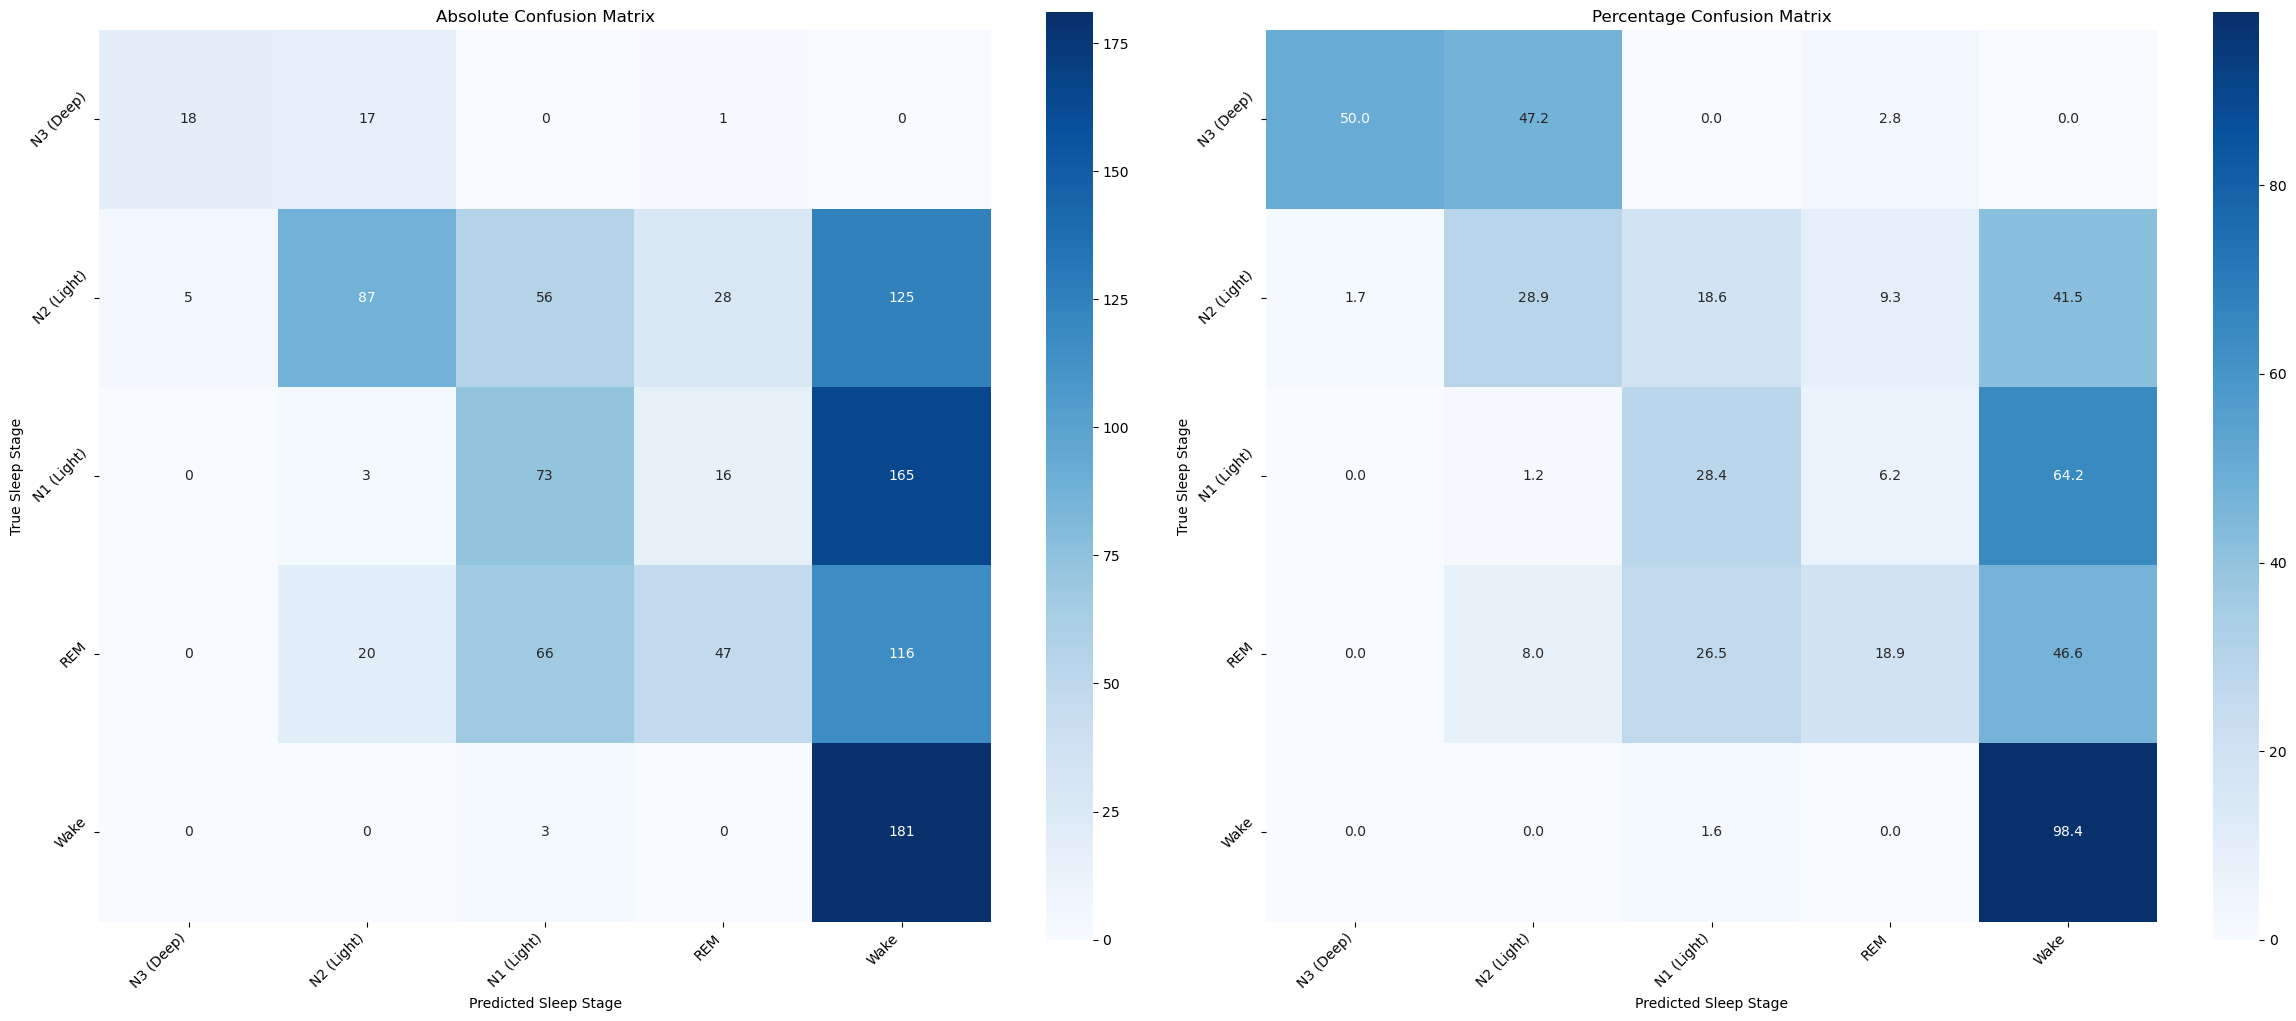


Results:
--------------------------------------------------
Overall Accuracy: 39.5%
Macro F1-Score: 41.7%
Weighted F1-Score: 37.2%
--------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

   N3 (Deep)       0.78      0.50      0.61        36
  N2 (Light)       0.69      0.29      0.41       301
  N1 (Light)       0.37      0.28      0.32       257
         REM       0.51      0.19      0.28       249
        Wake       0.31      0.98      0.47       184

    accuracy                           0.40      1027
   macro avg       0.53      0.45      0.42      1027
weighted avg       0.50      0.40      0.37      1027



In [16]:
import json

# File paths
model_weights_path = './models/new7/best_model.pt'
model_params_path = './models/new7/model_config.json'
x_data_path = './data/data.mat'
y_data_path = './data/labels.mat'




with open(model_params_path, 'r') as f:
    config = json.load(f)
    model_params = config['model_params']

results = evaluate_paper_data(
    model_path=model_weights_path,
    model_params=model_params,
    x_data_path=x_data_path,
    y_data_path=y_data_path,
    batch_size=32,
)



